# A maximally simple solution to CT / CTA detection!

In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
import os
from glob import glob

In [2]:
DICOM_PATH = 'data/dicom_dir/'

In [3]:
class Cohort(object):
    """ 
    Manages a cohort of datasets, finding what datasets are available, reading data and GT.
    Deals only with the raw input data - no normalization happens here
    """
    def __init__(self):
        """ The constructor scans the data path to find what data is present and
        setup a list and dictionary of dataset ids and paths.  It does not *read*
        the data"""
        self.dicom_path = 'data/dicom_dir/'
        self.filepaths = glob(DICOM_PATH + '*.dcm')
        self.ids = [os.path.basename(fp)[:7] for fp in self.filepaths]
        self.id_to_path_map = {id: path for id, path in zip(self.ids, self.filepaths)}
        self.size = len(self.ids)
        
        # Private cache storage
        self._images = self._dicoms = None
        
    @property
    def dicoms(self):
        """ Lazily read and return a list of dicom objects in the same order as self.ids """
        if self._dicoms is None:
            self._dicoms = [pydicom.dcmread(fp) for fp in self.filepaths]
        return self._dicoms
        
    @property
    def images(self):
        """ Lazily extract and a list of images (2d numpy arrays) in the same order as self.ids """
        if self._images is None:
            self._images = [dcm.pixel_array for dcm in self.dicoms]
        return self._images


def test_cohort_init():
    cohort = Cohort()
    # print(datasets.ids)
    # print(datasets.id_to_path_map)
    assert len(cohort.ids) == 100
    assert len(cohort.ids[0]) == 7 and cohort.ids[0][:3] == 'ID_'
    assert os.path.exists(cohort.filepaths[0])
    print("test_cohort_init passed.")
    
def test_cohort_accessors():
    cohort = Cohort()
    assert len(cohort.dicoms) == len(cohort.ids)
    assert all(['PixelData' in dcm for dcm in cohort.dicoms])
    assert len(cohort.images) == len(cohort.ids)
    assert all([im.shape == (512, 512) for im in cohort.images])
    assert all([cohort.images[0].dtype == np.int16])

    print("test_cohort_accessors passed.")
    
test_cohort_init()
test_cohort_accessors()
    

test_cohort_init passed.
test_cohort_accessors passed.


In [4]:
def explore_cohort():
    cohort = Cohort()
    df = pd.DataFrame(columns=['ID', 'MinV', 'MaxV', 'Slope', 'Incpt', 'MmPerPix', 'Padding'])
    for ix in range(cohort.size):
        image = cohort.images[ix]
        dcm = cohort.dicoms[ix]
        id_ = cohort.ids[ix]
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        mmpp_x, mmpp_y = dcm.data_element('PixelSpacing').value
        assert mmpp_x == mmpp_y
        row = (id_, np.min(image), np.max(image), slope, intercept, mmpp_x, padding)

        df.loc[ix] = row
    return df
        
explore_cohort()
    

,ID,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
0,ID_0096,-1024,2187,1.0,-1024.0,0.90,63536
1,ID_0012,0,2505,1.0,-1024.0,0.74,None
2,ID_0068,0,2476,1.0,-1024.0,0.98,None
3,ID_0045,0,4095,1.0,-1024.0,0.98,None
4,ID_0051,-1024,4095,1.0,-1024.0,0.75,63536
5,ID_0084,0,2148,1.0,-1024.0,0.98,None
6,ID_0089,-1024,2190,1.0,-1024.0,0.70,63536
7,ID_0014,0,4095,1.0,-1024.0,0.66,None
8,ID_0063,0,3029,1.0,-1024.0,0.98,None
9,ID_0016,0,2194,1.0,-1024.0,0.78,None


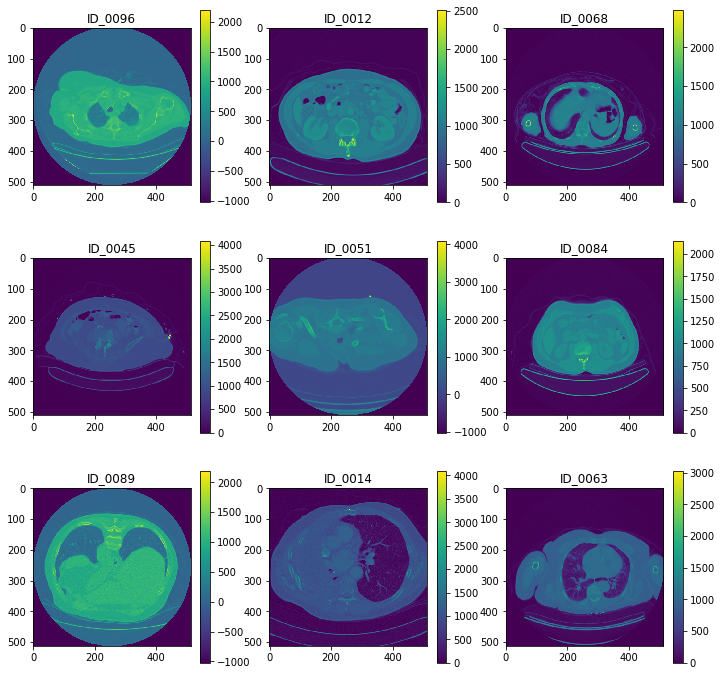

In [5]:
def show_images():
    cohort = Cohort()
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
    for ix, ax in enumerate(axes.flat):   # Show just a selection
        im = cohort.images[ix]
        pltim = ax.imshow(im)
        ax.set_title(cohort.ids[ix])
        cbar=fig.colorbar(pltim, ax=ax)
    plt.show()
        
show_images()